In [30]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

In [31]:
#@save
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
#         print('xxxx',X.shape)
        X = self.embedding(X)
#         print('xxxx2',X.shape)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [32]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
print(output.shape)
print(state.shape)

torch.Size([7, 4, 16])
torch.Size([2, 4, 16])


In [33]:
# class Seq2SeqDecoder(d2l.Decoder):
#     """用于序列到序列学习的循环神经网络解码器"""
#     def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
#                  dropout=0, **kwargs):
#         super(Seq2SeqDecoder, self).__init__(**kwargs)
#         self.embedding = nn.Embedding(vocab_size, embed_size)
#         self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
#                           dropout=dropout)
#         self.dense = nn.Linear(num_hiddens, vocab_size)

#     def init_state(self, enc_outputs, *args):
#         return enc_outputs[1]

#     def forward(self, X, state):
#         # 输出'X'的形状：(batch_size,num_steps,embed_size)
#         print('X',X.shape)
#         X = self.embedding(X).permute(1, 0, 2)
#         print('X',X.shape)
#         # 广播context，使其具有与X相同的num_steps
#         print('state[-1]',state[-1].shape)
#         context = state[-1].repeat(X.shape[0], 1, 1)
#         print('context',context.shape)
#         X_and_context = torch.cat((X, context), 2)
#         print('X_and_context', X_and_context.shape)
#         output, state = self.rnn(X_and_context, state)
#         print('output', output.shape)
#         output = self.dense(output).permute(1, 0, 2)
#         # output的形状:(batch_size,num_steps,vocab_size)
#         # state的形状:(num_layers,batch_size,num_hiddens)
#         return output, state

In [34]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出'X'的形状：(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        print('X', X.shape)
        # 广播context，使其具有与X相同的num_steps
        # 广播context的形状：[num_steps,batch_size,num_hiddens]
        context = state[-1].repeat(X.shape[0], 1, 1)
        print('context',context.shape)
        X_and_context = torch.cat((X, context), 2)
        print('X_and_context',X_and_context.shape)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [35]:
#@save
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))


tensor([[1, 0, 0],
        [4, 5, 0]])

In [66]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        print('unweighted_loss', unweighted_loss)
        print('weights',weights)
        print('(unweighted_loss * weights)',(unweighted_loss * weights))
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [67]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), 
     torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

unweighted_loss tensor([[2.3026, 2.3026, 2.3026, 2.3026],
        [2.3026, 2.3026, 2.3026, 2.3026],
        [2.3026, 2.3026, 2.3026, 2.3026]])
weights tensor([[1, 1, 1, 1],
        [1, 1, 0, 0],
        [0, 0, 0, 0]])
(unweighted_loss * weights) tensor([[2.3026, 2.3026, 2.3026, 2.3026],
        [2.3026, 2.3026, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]])


tensor([2.3026, 1.1513, 0.0000])

In [68]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            print('y.shape',Y.shape)
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            print('bos.shape',bos.shape)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            print('dec_input',dec_input)
            break
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()      # 损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

y.shape torch.Size([64, 10])
bos.shape torch.Size([64, 1])
dec_input tensor([[  2,  12,  51,   0,   4,   3,   1,   1,   1,   1],
        [  2,  20,   0,   5,   3,   1,   1,   1,   1,   1],
        [  2,   0,   9,   3,   1,   1,   1,   1,   1,   1],
        [  2,  79,   0,   9,   3,   1,   1,   1,   1,   1],
        [  2,   0,   5,   3,   1,   1,   1,   1,   1,   1],
        [  2,  91,  12,   5,   3,   1,   1,   1,   1,   1],
        [  2,  71,  28,   5,   3,   1,   1,   1,   1,   1],
        [  2,   0,   4,   3,   1,   1,   1,   1,   1,   1],
        [  2, 139,   4,   3,   1,   1,   1,   1,   1,   1],
        [  2,   0,   0,   5,   3,   1,   1,   1,   1,   1],
        [  2,   0,   5,   3,   1,   1,   1,   1,   1,   1],
        [  2,  13,   0,   5,   3,   1,   1,   1,   1,   1],
        [  2, 147,   0,  48,   4,   3,   1,   1,   1,   1],
        [  2, 110,  32,  68,   5,   3,   1,   1,   1,   1],
        [  2, 119,   5,   3,   1,   1,   1,   1,   1,   1],
        [  2,  63,  14,   0,   

ZeroDivisionError: float division by zero

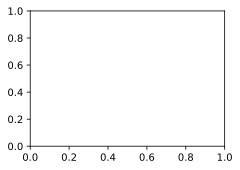

In [69]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [73]:
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    print('src_tokens',src_tokens)
    # 添加批量轴,enc_X[batch_size,num_steps]
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    print('enc_X',enc_X.shape)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    print('dec_X_shape',dec_X.shape)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        print('y_shape',Y.shape)
        print(Y)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2) # 返回的不是值，而是索引
        print('dec_X_shape',dec_X.shape)
        print('dec_X',dec_X)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        print('pred',pred)
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [74]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [75]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
#     print('eng',eng,'fra',fra)
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

src_tokens [9, 4, 3, 1, 1, 1, 1, 1, 1, 1]
enc_X torch.Size([1, 10])
dec_X_shape torch.Size([1, 1])
X torch.Size([1, 1, 32])
context torch.Size([1, 1, 32])
X_and_context torch.Size([1, 1, 64])
y_shape torch.Size([1, 1, 201])
tensor([[[-0.0864,  0.1495, -0.0067,  0.0823, -0.0218, -0.1634, -0.2063,
           0.0320,  0.0340, -0.3279,  0.3215, -0.0486,  0.2440,  0.1849,
          -0.0067, -0.0674,  0.1498, -0.1311, -0.0817, -0.0079, -0.2287,
          -0.1816,  0.2593, -0.2973, -0.1252, -0.0010,  0.0856, -0.0122,
           0.0763,  0.0943, -0.1187, -0.0104, -0.0452, -0.0320, -0.1806,
          -0.1655,  0.0398, -0.0543,  0.0652, -0.1703, -0.0205, -0.0313,
          -0.0663,  0.0510, -0.0657,  0.0954,  0.2313, -0.0750,  0.0710,
          -0.1380,  0.0152,  0.0038,  0.0152, -0.1385, -0.0718,  0.2060,
          -0.2164, -0.1913,  0.1174, -0.0973,  0.2391,  0.2771, -0.0552,
          -0.0554,  0.1871,  0.1110,  0.0016,  0.0892,  0.1291, -0.1686,
          -0.0333, -0.2203, -0.2377,  0.0133, 

In [43]:
torch.tensor([[1,2,3],[3,2,5],[7,3,8]]).argmax(dim=0)

tensor([2, 2, 2])

In [44]:
a = torch.tensor([[[1,2,3]]])
a.shape

torch.Size([1, 1, 3])

In [45]:
b = torch.tensor([[[4,5,6]]])
b.shape

torch.Size([1, 1, 3])

In [46]:
torch.cat((a, b), 2)

tensor([[[1, 2, 3, 4, 5, 6]]])

In [47]:
torch.cat((a, b), 2).shape

torch.Size([1, 1, 6])

In [80]:
from collections import defaultdict

s = [('yellow', 1), ('blue', 2), ('yellow', 3), ('blue', 4), ('red', 1)]
d = defaultdict(list)
for k, v in s:
    d[k].append(v)

sorted(d.items())

[('blue', [2, 4]), ('red', [1]), ('yellow', [1, 3])]

In [83]:
a = {}
b = defaultdict(list)

In [84]:
b['a'] = 123

In [86]:
type(b['a'])

int

In [87]:
import torch
x = torch.tensor([1,2])
y = torch.tensor([[5,6,7],[8,9,10]])
print(torch.matmul(x,y),torch.matmul(x,y).size())


tensor([21, 24, 27]) torch.Size([3])


In [89]:
x = torch.tensor([1,2])
y = torch.tensor([5,6])
print(torch.matmul(x,y),torch.matmul(x,y).size())

tensor(17) torch.Size([])


In [93]:
import torch
x = torch.tensor([[1,2,3],[4,5,6]])
y = torch.tensor([7,8,9])
print(torch.matmul(x,y),'\n',torch.matmul(x,y).size())


tensor([ 50, 122]) 
 torch.Size([2])


In [95]:
a = y.unsqueeze(1)

In [96]:
print(torch.matmul(x,a),'\n',torch.matmul(x,a).size())

tensor([[ 50],
        [122]]) 
 torch.Size([2, 1])


In [97]:
y[:,None]

tensor([[7],
        [8],
        [9]])

In [98]:
torch.matmul(x,a).squeeze(1)

tensor([ 50, 122])